# ICT nudging pipelines notebook

## Introduction

This notebook is part of a series of notebooks presenting the numerical simulations, and the results, for the article **"Realistic Nudging through ICT Pipelines to Help Improve Energy Self-Consumption for Management in Energy Communities".**

### General description

Our model comprises two parts:

1. a **simulated part** which simulates an household consuming energy, and reacting to nudges.

2. a **real world part** which contains the true algorithms processing the available information, and constructing the nudges.

The scheme below shows the various parts of our model. The real world algorithms are plugged on the simulated part, but they can be unplugged, and plugged into the "real world".

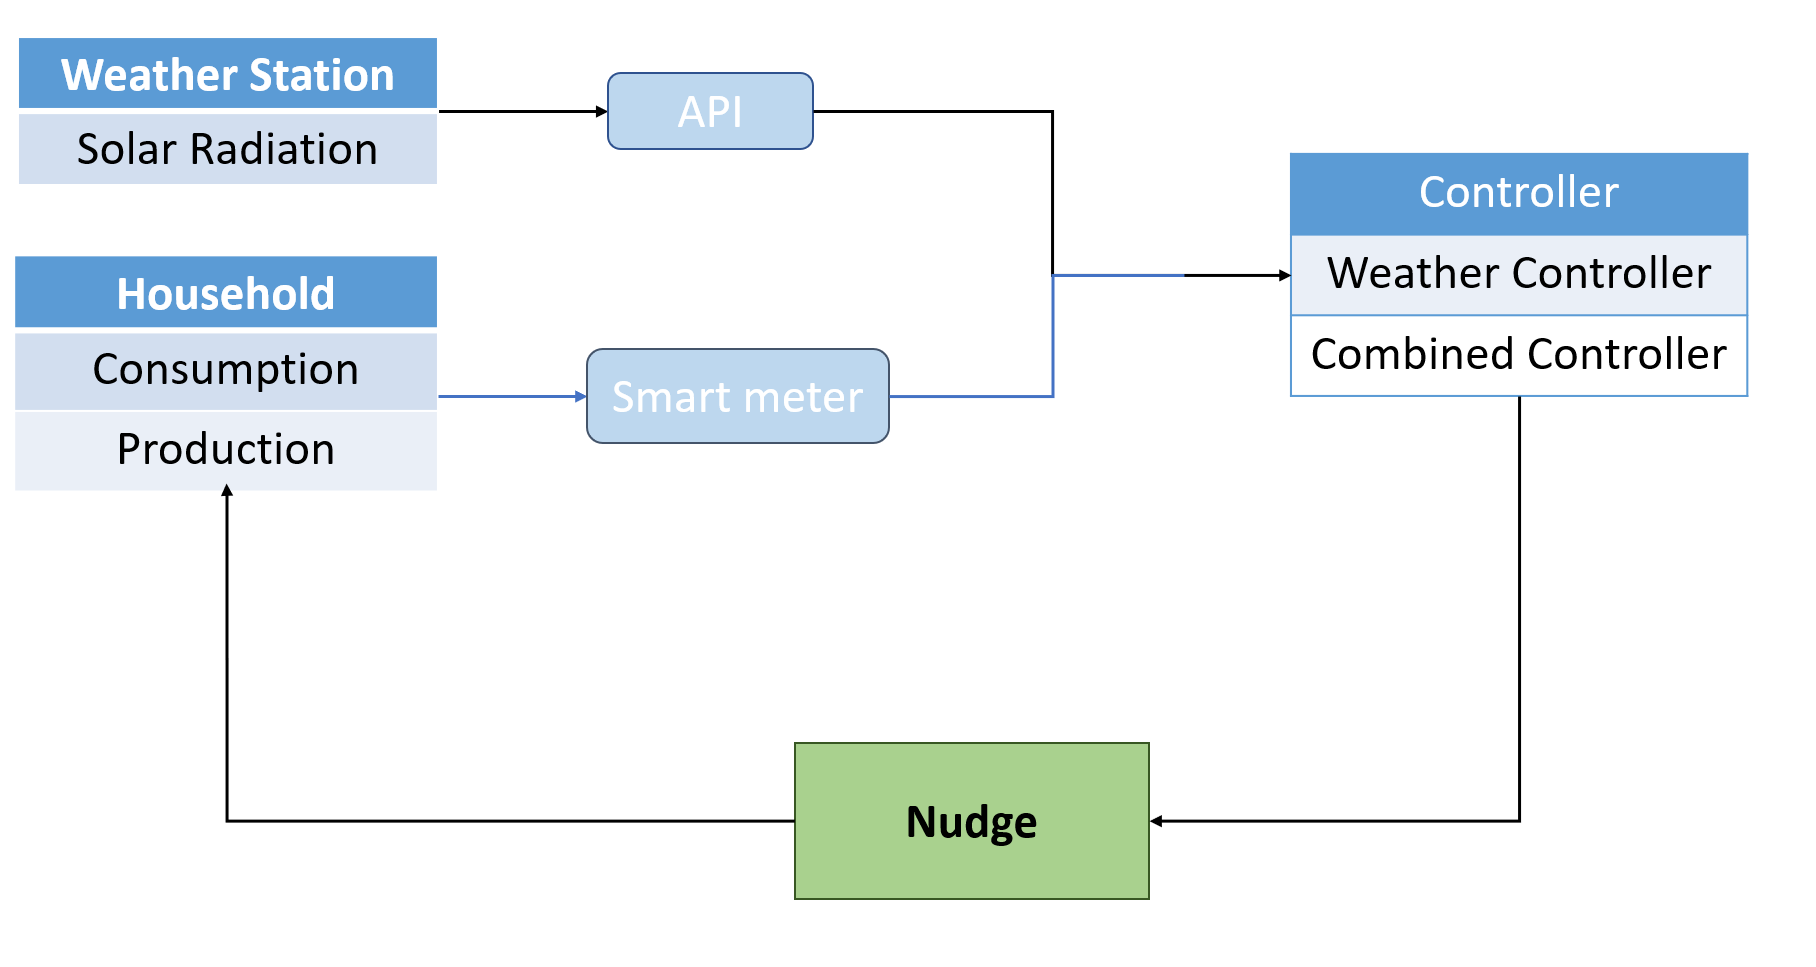

In [1]:
from IPython.display import Image
Image(filename='NudgingPipeline.PNG') 

### Case study 

The numerical simulations presented in **Section 4.5.** illustrate the efficiency of our nudging pipelines in improving the self-production, and self-consumption rates of the real household.

Our case study is conducting on a real data set Iris dataset. **The Iris dataset** is a collection of residential energy consumption data from **98 houses** spanning a period of **one year**, and is a **subset** of a **European database** gathered as part of the **REMODECE project**.


In this study, we conducted simulations on **three distinct subsets** of the Iris dataset. The **first subset** encompassed buildings with **a single shiftable appliance**, the **second subset** included buildings with **two shiftable appliances**, and the **third subset** comprised buildings with **three or more shiftable appliances**. We compared the results of these simulations to the simulation on the entire Iris dataset to demonstrate that **our controllers perform better for buildings with a higher number of shiftable appliances, indicating greater energy flexibility**.  

<font color="red">We are unable to provide the Iris Dataset for this notebook due to licensing restrictions. However, you can still use this notebook by providing your own dataset to run the simulations. Make sure to set the timeline parameters of your new dataset for the simulation.</font>

## Setting-up the model and the simulation parameters

We first obtain the absolute path of the current working directory, and import some utils modules.

In [2]:
import pandas as pd
import os
path = os.path.abspath(os.path.dirname(os.getcwd()))
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(path)
from src.utils import set_simulation_config as sconf
from src.utils import util_functions as ut
import utils_notebook as ub

### Set simulation parameters

The simulation depends on various parameters, related to the different aspects of the model, in the simulated world, and the real world algorithms.

In the **simulated world**, we have:

1. the **household**;


2. the **solar pannels**;


3. the **general simulation settings.**

The **real world algorithms** are
1. the **controllers** (algorithms which process information and send nudges to the household).

**There are several parameters in the simulation configuration whose values we have fixed**,and for more information, please refer to the notebook "[simple example](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/open_source/Notebook_Exemple/Simple_example.ipynb "Go to Example notebook").". 


We define below the main parameters, and briefly comment on them.

### Household settings - Get all data location

Here, all that is required is to get the location of the all household data. For each data file we determine the shiftable and non-shiftable profiles.

In [3]:
path  = "C:\\Users\\lingh\\projet_enogrid\\projet_acc\\ml_nudge_acc\\data\\inputs\\iris" ## add your own dataset directory
all_file_path = ut.get_all_file_path_in_one_dir(path)

###  Solar pannels
The variable **coeff_sunshine_to_prod** represents the capacity, in Watts, of the solar pannels (that is, their production when sunshine is at its maximum).

Please refer to the notebook for explanations about this choice ["Influence of the Amount of Production"](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/py_notebooks/Notebook_Exemple/Influence%20of%20the%20Amount%20of%20Production%20.ipynb) and refer to the **Section 4.6.** in our paper.

In [4]:
coeff_shunshin_to_prode = [1900]

During the simulation, we compute synthetic sunshine coefficients. They depend on the time of day, the month of year, and the level of clouds. The sequence of clouds is modelled as a Markov Chain. It is therefore stochastic.

### Controllers settings


We set parameters for our two controllers: Weather Controller, and Combined Controller.

1. **nb_periods_max** : This parameter sets the maximum number of **green periods** labelled by a nudge,The default value is 4. It's a parameter for both Controller and we did a study for illustrating the influence of the number of green periods on a simulation. For more information please refer to the notebook ["Influence of the Number of Green Periods"](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/open_source/Notebook_Exemple/Influence%20of%20the%20Number%20of%20Green%20Periods.ipynb) and refer to the **Section 4.7.** in our paper.


2. **predictor_type** : this parameter specifies the type of energy forecasting model to use for the Combined Controller. There are two options: a "simple" model (using as consumption prediction past consumption averages for each day, and each 30 minutes time slot), and a "Random Forest" model.

In [5]:
nb_periods_max = [4]
predictor_type = "simple"

### General Simulation Settings

Here are some important general parameters for the simulation:

1. **Timeline Data** :The timeline data is used to define both the historical data (**historical_data_begin** and **historical_data_end**) for training energy forecasting models and the simulation data(**begin_simulation** and **length_of_simulation**) for nudging simulations. 


2. **nb_runs** : The number of simulation runs.



3. **run_optimisation** : If **True**, compare the simulation results obtained from the nudge algorithm with the results obtained from the optimization algorithm calculated by OMEGalpes. **OMEGAlpes** is **a linear optimization tool** designed to easily generate multi-carrier energy system models. Its purpose is to assist in developing district energy projects by integrating design and operation in pre-studies phases. For more informations, please refer to [OMEGalpes](https://omegalpes.readthedocs.io/en/stable/about_OMEGAlpes.html)

In [6]:
nb_runs = 3
run_optimisation = True
historical_data_begin = "04/09/2019"
historical_data_end = "10/07/2019" 
begin_simulation = "10/13/2019"
length_of_simulation = 33

## Metrics studied


1. **Self_consumption rate**: it refers to the percentage of the electricity generated by a renewable energy system that is consumed on-site by the system owner, rather than being exported to the grid. 


2. **self-sufficiency rate**: it refers to the proportion of electricity that is generated by an energy source and consumed on-site, relative to the total electricity consumption of the site.


**For more informations, please refer to Section 3.2. of our paper.**

## Create a timeout function

Occasionally, we encounter issues with infeasible optimization or optimization that fails to converge. To prevent these problems, we have implemented a timeout function that interrupts the optimization if it takes longer than 30 minutes to complete.

In [7]:
## Create a timeout functionfrom func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(1800)  ## set timeout for 30min
def mytest2():
    simconf = sconf.SimulationConfig(file,
                                    predictor_type=predictor_type,
                                    historical_data_begin=historical_data_begin,
                                    historical_data_end=historical_data_end,
                                    begin_simulation=begin_simulation,
                                    length_of_simulation=length_of_simulation)
    sim = sconf.RunSimulation(
        simconf,
        run_optimisation=run_optimisation,
        nb_runs=nb_runs,
        nb_periods_max=nb_periods_max,
        coeff_sunshine=coeff_shunshin_to_prode,
    )
    result = sim.run_simulation()
    
    return result

## Create distinct subsets

In [8]:
building_three_app =[]
building_two_app = []
building_one_app = []
shiftable_appliances = ['washing_machine','dish_washer','water_heater',"clothes iron","washer dryer","clothes_washer"]
for file in all_file_path:
    count = 0
    building_data = pd.read_csv(file, index_col=0, parse_dates=True)
    shift_app_nb = len([col for col in building_data.columns if col in shiftable_appliances])
    if shift_app_nb == 3:
        building_three_app.append(file)
    elif shift_app_nb==1:
        building_one_app.append(file)
    elif shift_app_nb==2:
        building_two_app.append(file)
    else:
        pass

## Running simulations

We now run our simulations on the first subset (one shiftable appliance), with the parameters we have defined.

In [ ]:
all_result = pd.DataFrame()
for file in building_one_app:
    try:
        result = mytest2()
        all_result = pd.concat([all_result,result],axis=1)
    except:
        continue

## Visualisation

In addition to our two controllers, we present the following two results:

- Reference : The **absence of nudging** serves as the **lower bound** in terms of reference.


- Omegalpes : It represents an **optimization approach** aimed at **maximizing the self-consumption/production rate**. It provides a performance **upper bound**. It uses unrealistic information (detailed dissagregated knowledge of the future consumption), and thus cannot be used as a nudging algorithm.

### Self_consumption rate
We first study the self-consumption rate.

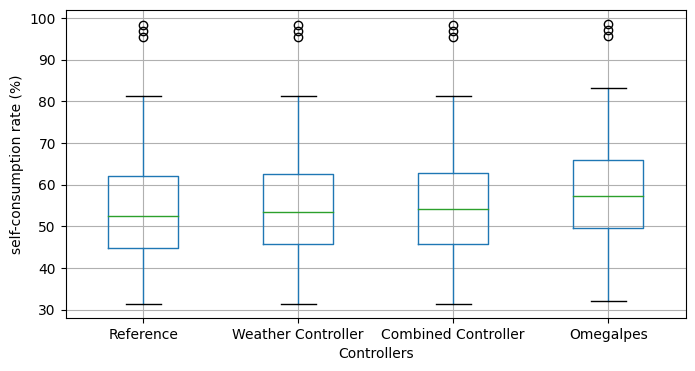

In [19]:
self_consumption_rate_result = ub.visualisation_results_of_all_simulations(all_result,'consumption')

We see that both our controllers improve the self-consumption rate, with respect to the Reference case. Detailed values are provided below.

In [20]:
self_consumption_rate_result.mean()

Reference              54.401715
Weather Controller     54.972688
Combined Controller    55.183176
Omegalpes              58.453935
dtype: float64

### self-sufficiency rate
Now, we study the self-sufficiency rate

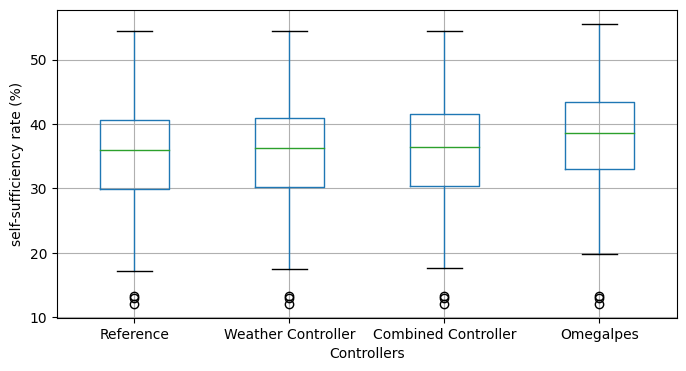

In [22]:
self_sufficiency_rate_result = ub.visualisation_results_of_all_simulations(all_result,'production')

We see that both our controllers improve the self-sufficiency rate, with respect to the Reference case. Detailed values are provided below.

In [23]:
self_sufficiency_rate_result.mean()

Reference              34.577678
Weather Controller     34.988522
Combined Controller    35.120441
Omegalpes              37.131701
dtype: float64

## Improvement ratio : the improvement by different controller compare with the improvement of omegalpes


We compute the improvement ratio of different controllers compared to Omegalpes using the equations: 

$$ Ratio\_WeatherController =\frac{\text{self_consumption_rate}_{weather} - \text{self_consumption_rate}_{\text{reference}}}{\text{self_consumption_rate}_{Omegalpes} - \text{self_consumption_rate}_{reference}} $$

$$ Ratio\_CombinedController =\frac{\text{self_consumption_rate}_{combined} - \text{self_consumption_rate}_{reference}}{\text{self_consumption_rate}_{Omegalpes} - \text{self_consumption_rate}_{reference}} $$

The improvement ratios calculated using self-consumption rate and self-sufficiency rate are identical. Therefore, we will calculate the improvement ratio using only the self-consumption rate.

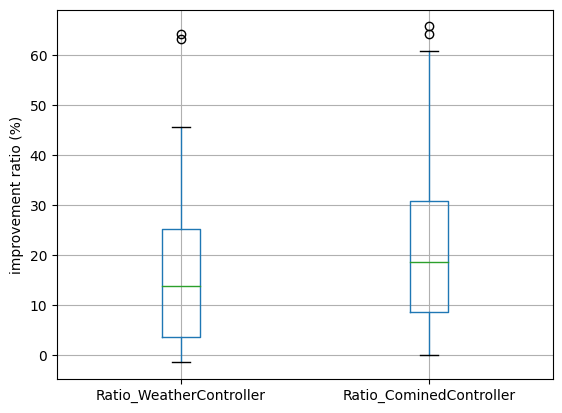

In [25]:
ratio = ub.calculate_improvement_ratio (self_consumption_rate_result)

## Average improvement ratio

In [26]:
ratio.mean()

Ratio_WeatherController    16.316830
Ratio_CominedController    20.864329
dtype: float64

## Running simulations
We now run our simulations on the second subset (deux shiftable appliances), with the parameters we have defined

In [ ]:
all_result = pd.DataFrame()
for file in building_two_app:
    try:
        result = mytest2()
        all_result = pd.concat([all_result,result],axis=1)
    except:
        continue

### Self_consumption rate
We first study the self-consumption rate.

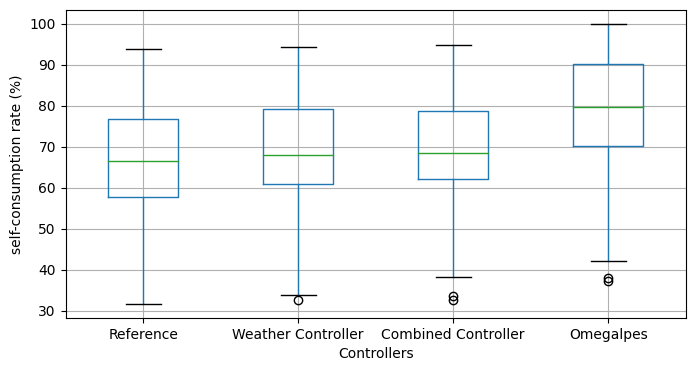

In [29]:
self_consumption_rate_result = ub.visualisation_results_of_all_simulations(all_result,'consumption')

In [30]:
self_consumption_rate_result.mean()

Reference              66.771220
Weather Controller     68.641978
Combined Controller    69.097998
Omegalpes              78.514127
dtype: float64

### Self-sufficiency rate

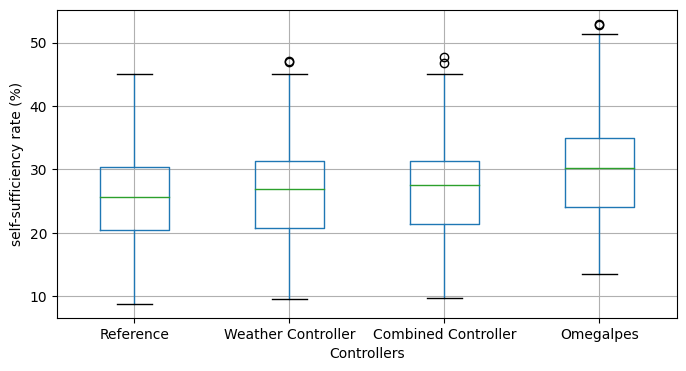

In [32]:
self_sufficiency_rate_result = ub.visualisation_results_of_all_simulations(all_result,'production')

In [33]:
self_sufficiency_rate_result.mean()

Reference              25.660987
Weather Controller     26.410152
Combined Controller    26.590107
Omegalpes              30.051250
dtype: float64

## Improvement ratio

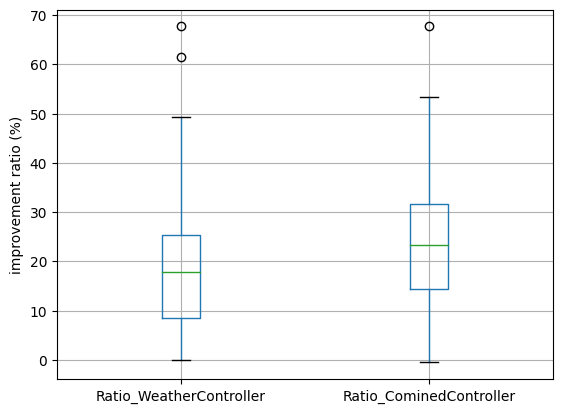

In [35]:
ratio = ub.calculate_improvement_ratio (self_consumption_rate_result)

In [36]:
ratio.mean()

Ratio_WeatherController    18.430253
Ratio_CominedController    22.863909
dtype: float64

## Running simulations
We now run our simulations on the third subset (three or more shiftable appliances), with the parameters we have defined.

In [ ]:
all_result = pd.DataFrame()
for file in building_three_app:
    try:
        result = mytest2()
        all_result = pd.concat([all_result,result],axis=1)
    except:
        continue

### Self-consumption rate

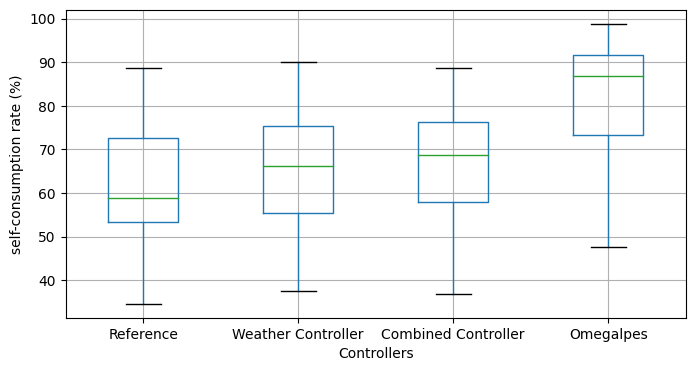

In [10]:
self_consumption_rate_result = ub.visualisation_results_of_all_simulations(all_result,'consumption')

In [11]:
self_consumption_rate_result.mean()

Reference              60.911142
Weather Controller     64.161572
Combined Controller    65.307848
Omegalpes              81.321027
dtype: float64

### Self-sufficiency rate

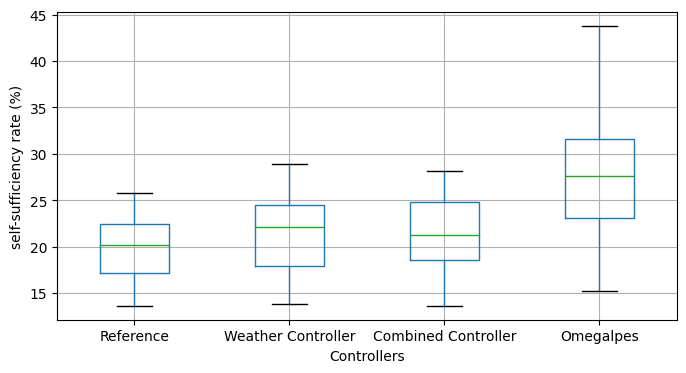

In [13]:
self_sufficiency_rate_result = ub.visualisation_results_of_all_simulations(all_result,'production')

In [14]:
self_sufficiency_rate_result.mean()

Reference              20.070261
Weather Controller     21.270621
Combined Controller    21.659774
Omegalpes              27.716824
dtype: float64

## Improvement ratio

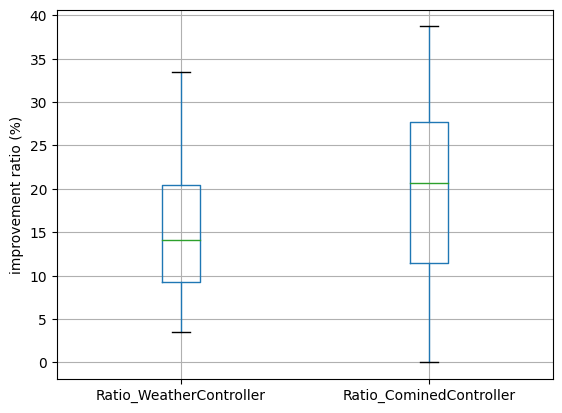

In [16]:
ratio = ub.calculate_improvement_ratio (self_consumption_rate_result)

In [17]:
ratio.mean()

Ratio_WeatherController    15.402341
Ratio_CominedController    19.372446
dtype: float64

## Conclusion

In simulations performed on the **first subset**, both controllers exhibited a slight improvement in the self-consumption rate, increasing it from 54.4% to approximately 55%. **The observed self-consumption rate improvement for both controllers was less than 1%.**

Moving on to the simulations conducted on the **second subset**, we observed a notable enhancement in the self-consumption rate. For the Weather Controller, the self-consumption rate increased from 66.77% to 68.64%, while for the Combined Controller, it rose to 69.1%. **The self-consumption rate improvement for this subset was approximately 2%.**

Finally, in simulations performed on the **third subset**, a significant improvement in the self-consumption rate was observed. For the Weather Controller, the self-consumption rate increased from 60.91% to 64.16%, and for the Combined Controller, it reached 65.31%. **The self-consumption rate improvement for this subset was approximately 4%, which is substantially higher compared to the previous subsets.**

**Our observations indicate a positive correlation between the improvement in the self-consumption rate and the number of shiftable appliances or energy flexibility within the houses under similar conditions such as weather and house type.**

Furthermore, considering all subsets collectively, the **percentage improvement relative to the OMEGalpes** reference ranged consistently from approximately **15% to 22%.**